In [1]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import statistics
from math import pow
import numpy as np

In [2]:
pCross = 0.7 #probabilitas pindah silang / menghasilkan offspring
pMutasi = 0.03 #probabilitas mutasi
popSize = 30 #jumlah individu dalam satu populasi
pKrom = 15 #panjang satu kromosom

Read Data


In [3]:
data_trainning = pd.read_csv('dataset.csv')
trainSize = len(data_trainning)
isi_nilai = data_trainning[['Suhu', 'Waktu', 'Kondisi Langit', 'Kelembapan', 'Terbang/Tidak']].values

#data_trainning

String to Biner

In [4]:
def encodingRules(data_input):
    rules = []
    kondisi = []
    data = [['Rendah', 'Normal', 'Tinggi'],[ 'Pagi', 'Siang', 'Sore', 'Malam'], ['Cerah', 'Berawan', 'Rintik', 'Hujan'], ['Rendah', 'Normal', 'Tinggi']]
    for i in range(len(data_input)-1):
        for j in range(len(data[i])):
            if data_input[i] == data[i][j]:
                kondisi.append(1)
            else:
                kondisi.append(0)
        rules.append(kondisi)
        kondisi = []
    if data_input[i+1] == 'Tidak':
        rules.append([0])
    else:
        rules.append([1])
    return rules

In [5]:
listRules = []
for i in range (len(isi_nilai)):
    listRules.append(encodingRules(isi_nilai[i]))


In [6]:
def setTransform(r):
    temp = []
    rbaru = []
    i = 0
    while (i < len(r)):
        if (i == 3 or i == 7 or i == 11 or i == 14):
            rbaru.append(temp)
            temp = []
            if (i == 14):
                rbaru.append([r[i]])
        temp.append(r[i])
        i += 1
    return rbaru

In [7]:
def bagiRules(R):
    i = 0
    Lrules = []
    while (i < len(R)):
        Lrules.append(setTransform(R[i:i+15]))
        i += 15   
    return Lrules

In [8]:
class Kromosom:
    def __init__(self, representasi):
        self.biner = representasi
        
    def getR(self):
        return self.biner
    
    def getRules(self):
        return self.Lrules
    
    def setRules(self, R):
        self.Lrules = R
        
    def getFit(self):
        return self.fit
    
    def setFit(self, ukuranTotal, jumlah):
        self.fit = (jumlah/ukuranTotal)
        
    def setBenar(self, nilai):
        self.jumlahbenar = nilai
    
    def getBenar(self):
        return self.jumlahbenar
    
    def setPeluangFit(self, total):
        if (total == 0):
            self.peluangFit = 0
        else:
            self.peluangFit = (self.fit / total)

    def getPeluangFit(self):
        return self.peluangFit
    
    def setValid(self, valid):
        self.valid = valid
        
    def getValid(self):
        return self.valid

def hitungBenar(trainSet, DaftarRules):
    jumlahbenar = 0
    for daftardata in range (len(trainSet)):
        j = 0
        udahcocok = False
        while (j < len(DaftarRules) and udahcocok == False):
            if (setidaknyaSatu(DaftarRules[j])):
                if (setValue(trainSet[daftardata], DaftarRules[j])):
                    if (trainSet[daftardata][4] == DaftarRules[j][4]):
                        jumlahbenar += 1
                        udahcocok = True    
                elif (j == len(DaftarRules)-1):  
                    if (trainSet[daftardata][4] != DaftarRules[j][4]):
                        jumlahbenar += 1
                        udahcocok = True
            j += 1
    return jumlahbenar
    
def setidaknyaSatu(aturan):
    for i in range (len(aturan)-1):
        if (fungsiOr(aturan[i]) and not fungsiAnd(aturan[i])):
            return True
    return False
   
def setValue(bandingkan, aturan):
    nilaiAnd = []
    nilaiOr = []
    for i in range (len(aturan)-1):
        if (not fungsiOr(aturan[i])):
            nilaiAnd.append(bandingkan[i])
        else:
            nilaiAnd.append(np.logical_and(aturan[i], bandingkan[i]))
    for i in range (len(nilaiAnd)):
        nilaiOr.append(fungsiOr(nilaiAnd[i]))
    if (fungsiAnd(nilaiOr)):
        return True
    else:
        return False

def fungsiOr(dataOr):
    for i in range (len(dataOr)):
        if (dataOr[i] == 1):
            return True
    return False
def fungsiAnd(dataAnd):
    for i in range (len(dataAnd)):
        if (dataAnd[i] == 0):
            return False
    return True

In [9]:
def generate_populasi(size):
    pop = []
    for i in range(size): 
        ind = Kromosom(np.random.randint(2, size=(pKrom*2)))
        ind.setRules(bagiRules(ind.getR()).copy())
        nilaibenar = hitungBenar(listRules,ind.getRules())
        ind.setBenar(nilaibenar)   
        ind.setFit(trainSize, ind.getBenar())
        pop.append(ind)
    return pop

def totalFitness(semua_populasi):
    totalFitness = 0
    for i in range (len(semua_populasi)):
        totalFitness += (semua_populasi[i].getFit())
    return totalFitness  

#PAKAI ROULLETE WHEEL
def seleksi_ortu(semua_populasi):
    r = random.uniform(0, 1)
    i = 0
    while (r > 0 and i < len(semua_populasi)-1):
        r -= semua_populasi[i].getPeluangFit()
        i += 1
    return i

def cekKesamaan(darisilist, pembanding):
    for i in range (len(darisilist)):
        if (pembanding == darisilist[i]):
            return True
    return False

def possibleIndex(titikpotong, genSize, titikibu):
    possible = []
    p1 = titikpotong[1] - titikpotong[0]
    p2 = p1 % genSize
    if (titikpotong[0]+p2 < len(titikibu)):
        possible.append([titikpotong[0], titikpotong[0]+p2])
    if (titikpotong[1] < len(titikibu)):
        possible.append([titikpotong[1]-p2, titikpotong[1]])
        possible.append([titikpotong[0], titikpotong[1]])
    return possible

def rekombinasi(ayah, ibu): #HARUS DIUBAH
    rand = random.random()
    garispotong = []
    if rand <= pCross:
        for i in range(2):
            
            slicePoint = np.random.randint(0,len(ayah)-1)
            while (cekKesamaan(garispotong, slicePoint) or (slicePoint == 0)):
                slicePoint = np.random.randint(0,len(ayah)-1)
            garispotong.append(slicePoint)
        garispotong.sort()
        gap = garispotong[1]-garispotong[0]
        while ((gap < pKrom or garispotong[1] >= len(ibu)) and garispotong[1] >= len(ibu)):
            garispotong = []
            for i in range(2):
                slicePoint = np.random.randint(0,len(ayah)-1)
                while (cekKesamaan(garispotong, slicePoint) or (slicePoint == 0)):
                    slicePoint = np.random.randint(0,len(ayah)-1)
                garispotong.append(slicePoint)
            garispotong.sort()
        
        apacekcoba = possibleIndex(garispotong, pKrom, ibu)
        panjangnya = len(apacekcoba)
        if (panjangnya>1):
            randomId = np.random.randint(0,panjangnya)
        else:
            randomId = 0
        garisPotongIbu = apacekcoba[randomId]
        
        
        kakak = np.concatenate((ayah[:garispotong[0]],ibu[garisPotongIbu[0]:garisPotongIbu[1]],ayah[garispotong[1]:]))
        adik = np.concatenate((ibu[:garisPotongIbu[0]],ayah[garispotong[0]:garispotong[1]],ibu[garisPotongIbu[1]:]))
        
#         print("A1", kakak, "A2", adik)
    else:
        kakak = ayah.copy()
        adik = ibu.copy()
    return kakak, adik

def mutasi(kromosom):
    for i in range (len(kromosom)):
        rand = random.random()
        if rand <= pMutasi:
            kromosom[i] = 1 - kromosom[i]
    return kromosom

def tampilkan(arr):    
    for i in range(len(arr)):
        print("Fit        ", "Benar     ", "Kromosom     " , "Rules")
        print(arr[i].getFit(), arr[i].getBenar(), arr[i].getR(), arr[i].getRules())

def cek_konvergen(arr):
    cek_nilai = []
    for i in range (len(arr)):
        cek_nilai.append(arr[i].getFit())
    sd = statistics.stdev(cek_nilai)
    if (sd <= 0.0000000001):
        return True
    else:
        return False
        

pop = generate_populasi(popSize)
ToFit = totalFitness(pop)

for i in range(popSize):
    pop[i].setPeluangFit(ToFit)

pop.sort(key=lambda x: x.fit, reverse=True)

Generasi ke- 1
Individu Terbaik :  [0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0]
Fitness:  0.6125  Jumlah Benar :  49 Rules [[[0, 0, 0], [0, 0, 1, 0], [0, 1, 1, 1], [0, 1, 1], [0]], [[0, 1, 1], [0, 0, 1, 1], [0, 0, 1, 1], [1, 1, 1], [0]]]


Generasi ke- 2
Individu Terbaik :  [1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
Fitness:  0.6875  Jumlah Benar :  55 Rules [[[1, 1, 1], [1, 1, 1, 0], [1, 1, 0, 1], [0, 1, 1], [0]], [[1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0], [0, 1, 0], [0]]]


Generasi ke- 3
Individu Terbaik :  [1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
Fitness:  0.6875  Jumlah Benar :  55 Rules [[[1, 1, 1], [1, 1, 1, 0], [1, 1, 0, 1], [0, 1, 1], [0]], [[1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0], [0, 1, 0], [0]]]


Generasi ke- 4
Individu Terbaik :  [1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
Fitness:  0.8625  Jumlah Benar :  69 Rules [[[1, 1, 1], [1, 1, 1, 0], [0, 0, 0, 0], [1, 1, 1], [0]], [[0, 0, 0], [0, 0, 1, 0], [0, 0

Generasi ke- 25
Individu Terbaik :  [0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1
 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1
 0]
Fitness:  1.0  Jumlah Benar :  80 Rules [[[0, 0, 0], [1, 1, 1, 0], [0, 0, 0, 0], [1, 1, 1], [0]], [[0, 1, 1], [0, 0, 1, 1], [0, 1, 0, 1], [0, 1, 1], [0]], [[0, 0, 0], [0, 0, 1, 1], [0, 0, 0, 0], [1, 1, 1], [0]], [[0, 1, 1], [0, 0, 0, 0], [1, 1, 0, 1], [0, 1, 1], [0]], [[1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [1, 1, 1], [0]]]


Generasi ke- 26
Individu Terbaik :  [0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1
 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1
 0]
Fitness:  1.0  Jumlah Benar :  80 Rules [[[0, 0, 0], [1, 1, 1, 0], [0, 0, 0, 0], [1, 1, 1], [0]], [[0, 1, 1], [0, 0, 1, 1], [0, 1, 0, 1], [0, 1, 1], [0]], [[0, 0, 0], [0, 0, 1, 1], [0, 0, 0, 0], [1, 1, 1], [0]], [[0, 1, 1], [0, 0, 0, 0], [1, 1, 0, 1], [0, 1, 1], [0]], [[1, 0, 0], [0, 0, 1, 0

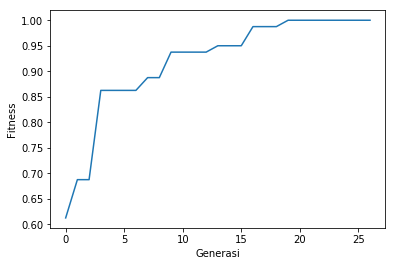

In [10]:
lFit = []
gen = 1
while not (cek_konvergen(pop)) or (pop[0].getBenar() != 80):
#for i in range (200):
    newPop = []
    
    #Elitism
    newPop.append(pop[0])
    newPop.append(pop[1])

    while (len(newPop) < len(pop)):
        #pilih orang tua
        ido1 = seleksi_ortu(pop)
        ido2 = seleksi_ortu(pop)
        if (ido1 == ido2):
            while (ido1 == ido2):
                ido2 = seleksi_ortu(pop)
        ortu1 = pop[ido1].getR()
        ortu2 = pop[ido2].getR()
        
        #CrossOver
        anak1, anak2 = rekombinasi(ortu1, ortu2)
            
        #Mutasi
        anak1 = mutasi(anak1)
        anak2 = mutasi(anak2)
        
        indA1 = Kromosom(anak1)
        indA1.setRules(bagiRules(indA1.getR()).copy())
        inijumlahyangbenar1 = hitungBenar(listRules,indA1.getRules())
        indA1.setBenar(inijumlahyangbenar1) 
        indA1.setFit(trainSize, indA1.getBenar())
        
        indA2 = Kromosom(anak2)
        indA2.setRules(bagiRules(indA2.getR()).copy())
        inijumlahyangbenar2 = hitungBenar(listRules,indA2.getRules().copy())
        indA2.setBenar(inijumlahyangbenar2)  
        indA2.setFit(trainSize, indA2.getBenar())
        
        newPop.append(indA1)
        newPop.append(indA2) 
        
    #tampilkan(newPop)
    semua = pop + newPop
    
    #sorting array dari objek individu berdasarkan nilai Fitnessnya
    semua.sort(key=lambda x: x.fit, reverse=True)
    
    #untuk populasi selanjutnya, diisi dengan individu dengan nilai fitness yang paling tinggi
    pop = []
    for i in range(popSize):
        pop.append(semua[i])
    
    #hitung kembali total Fitness semuanya untuk menentukan peluang untuk pemilihan seleksi orang tua di generasi selanjutnya
    ToFit = totalFitness(pop)
    for i in range(len(pop)):
        pop[i].setPeluangFit(ToFit)
        
    #tampilkan individu terbaik di generasi saat ini 
    print("Generasi ke-",gen)
    print("Individu Terbaik : ",pop[0].getR())
    print("Fitness: ", pop[0].getFit(), " Jumlah Benar : ", pop[0].getBenar(), "Rules", pop[0].getRules())
    #print("Fitness: ", pop[0].getBenar(), "ukuran Train", trainSize)
    print("")
    print("")
    
    #masukkan nilai fitness individu terbaik setiap generasi untuk plottingan grafik di akhir iterasi 
    lFit.append(pop[0].getFit())
    
    
    
    gen+= 1
plt.plot(lFit)
plt.xlabel('Generasi')
plt.ylabel('Fitness')
plt.show()


    

In [11]:
hitungBenar(listRules,pop[0].getRules())

80

In [12]:
data_uji = pd.read_csv('datauji.csv')
TestSize = len(data_uji)
isi_uji = data_uji[['Suhu', 'Waktu', 'Kondisi Langit', 'Kelembapan']].values
isi_uji

array([['Tinggi', 'Siang', 'Berawan', 'Rendah'],
       ['Rendah', 'Siang', 'Hujan', 'Tinggi'],
       ['Normal', 'Pagi', 'Hujan', 'Tinggi'],
       ['Tinggi', 'Siang', 'Hujan', 'Normal'],
       ['Rendah', 'Malam', 'Hujan', 'Rendah'],
       ['Normal', 'Sore', 'Cerah', 'Normal'],
       ['Tinggi', 'Siang', 'Rintik', 'Rendah'],
       ['Rendah', 'Siang', 'Cerah', 'Rendah'],
       ['Normal', 'Siang', 'Cerah', 'Rendah'],
       ['Tinggi', 'Siang', 'Hujan', 'Rendah'],
       ['Tinggi', 'Sore', 'Cerah', 'Tinggi'],
       ['Normal', 'Siang', 'Cerah', 'Tinggi'],
       ['Rendah', 'Pagi', 'Berawan', 'Normal'],
       ['Rendah', 'Malam', 'Rintik', 'Tinggi'],
       ['Normal', 'Siang', 'Hujan', 'Normal'],
       ['Tinggi', 'Malam', 'Cerah', 'Tinggi'],
       ['Rendah', 'Malam', 'Berawan', 'Rendah'],
       ['Rendah', 'Sore', 'Rintik', 'Normal'],
       ['Tinggi', 'Siang', 'Cerah', 'Rendah'],
       ['Rendah', 'Malam', 'Rintik', 'Normal']], dtype=object)

In [13]:
def encodingUji(data_input):
    rules = []
    kondisi = []
    data = [['Rendah', 'Normal', 'Tinggi'],[ 'Pagi', 'Siang', 'Sore', 'Malam'], ['Cerah', 'Berawan', 'Rintik', 'Hujan'], ['Rendah', 'Normal', 'Tinggi']]
    for i in range(len(data_input)):
        for j in range(len(data[i])):
            if data_input[i] == data[i][j]:
                kondisi.append(1)
            else:
                kondisi.append(0)
        rules.append(kondisi)
        kondisi = []
    return rules

In [14]:
listUji = []
for i in range (TestSize):
    listUji.append(encodingUji(isi_uji[i]))
    

In [15]:
listUji

[[[0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0]],
 [[1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1]],
 [[0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1]],
 [[0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0]],
 [[1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0]],
 [[0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0]],
 [[0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0]],
 [[1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0]],
 [[0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0]],
 [[0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0]],
 [[0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1]],
 [[0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1]],
 [[1, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0]],
 [[1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1]],
 [[0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0]],
 [[0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 1]],
 [[1, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [1, 0, 0]],
 [[1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0]],
 [[0, 0, 1], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0

In [16]:
def klasifikasi(TestSet, DaftarRules):
    jumlahbenar = 0
    for daftardata in range (TestSize):
        j = 0
        udahcocok = False
        while (j < len(DaftarRules) and udahcocok == False):
            if (setValue(TestSet[daftardata], DaftarRules[j])):
                TestSet[daftardata].append(DaftarRules[j][4])
                udahcocok = True    
            elif (j == len(DaftarRules)-1):  
                if (DaftarRules[j][4] == 1):
                    TestSet[daftardata].append([0])
                    udahcocok = True   
                else:
                    TestSet[daftardata].append([1])
                    udahcocok = True
            j += 1
    return TestSet

In [17]:
hasilnya = klasifikasi(listUji, pop[0].getRules())
hasilnya

[[[0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0], [0]],
 [[1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1], [0]],
 [[0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1], [0]],
 [[0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0], [0]],
 [[1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0], [0]],
 [[0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0], [0]],
 [[0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0], [0]],
 [[1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0], [0]],
 [[0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0], [0]],
 [[0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0], [0]],
 [[0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1], [0]],
 [[0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1], [0]],
 [[1, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0], [0]],
 [[1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1], [0]],
 [[0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0], [0]],
 [[0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 1], [0]],
 [[1, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [1, 0, 0], [0]],
 [[1, 0, 0], [

In [18]:
def decodeBiner(data_input):
    kondisi = []
    data = [['Rendah', 'Normal', 'Tinggi'],[ 'Pagi', 'Siang', 'Sore', 'Malam'], ['Cerah', 'Berawan', 'Rintik', 'Hujan'], ['Rendah', 'Normal', 'Tinggi']]
    for i in range (len(data_input)-1):
        for j in range(len(data_input[i])):
            if data_input[i][j] == 1:
                kondisi.append(data[i][j])
    if data_input[i+1] == [0]:  
        kondisi.append("Tidak")
    else:
        kondisi.append("Ya")
    return kondisi

In [19]:
hasilklasifikasi = []
for i in range (TestSize):
    temp = decodeBiner(hasilnya[i])
    hasilklasifikasi.append(temp[4])
    print(temp)

['Tinggi', 'Siang', 'Berawan', 'Rendah', 'Tidak']
['Rendah', 'Siang', 'Hujan', 'Tinggi', 'Tidak']
['Normal', 'Pagi', 'Hujan', 'Tinggi', 'Tidak']
['Tinggi', 'Siang', 'Hujan', 'Normal', 'Tidak']
['Rendah', 'Malam', 'Hujan', 'Rendah', 'Tidak']
['Normal', 'Sore', 'Cerah', 'Normal', 'Tidak']
['Tinggi', 'Siang', 'Rintik', 'Rendah', 'Tidak']
['Rendah', 'Siang', 'Cerah', 'Rendah', 'Tidak']
['Normal', 'Siang', 'Cerah', 'Rendah', 'Tidak']
['Tinggi', 'Siang', 'Hujan', 'Rendah', 'Tidak']
['Tinggi', 'Sore', 'Cerah', 'Tinggi', 'Tidak']
['Normal', 'Siang', 'Cerah', 'Tinggi', 'Tidak']
['Rendah', 'Pagi', 'Berawan', 'Normal', 'Tidak']
['Rendah', 'Malam', 'Rintik', 'Tinggi', 'Tidak']
['Normal', 'Siang', 'Hujan', 'Normal', 'Tidak']
['Tinggi', 'Malam', 'Cerah', 'Tinggi', 'Tidak']
['Rendah', 'Malam', 'Berawan', 'Rendah', 'Tidak']
['Rendah', 'Sore', 'Rintik', 'Normal', 'Tidak']
['Tinggi', 'Siang', 'Cerah', 'Rendah', 'Tidak']
['Rendah', 'Malam', 'Rintik', 'Normal', 'Tidak']


In [20]:
df = pd.DataFrame(hasilklasifikasi) 
df.to_csv('out.csv')